In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

In [62]:
## Select the appropriate database

backbone1 = []
fn = "/home/robert/data/mode_s_ts_1000_nb_10000_seed_45_.dat"
print('reading', fn)
with open(fn, 'r') as fid:
    for row in fid:
        row = row.split()
        # extract the fiber center (rectangular trapezoid)
        v = np.zeros(5)
        if -8 <= int(row[2]) <=8:
            if -8 <= int(row[4]) <=8:
                if -100 <= int(row[3]) <=100:
                    #print(row)
                    v = [
                        int(row[1]),  # particle id
                        int(row[2]),  # x
                        int(row[3]),  # y
                        int(row[4]),  # z                        
                    ]
                    backbone1.append(v)

backbone1 = np.array(backbone1, dtype=np.int32)
# print(back_bone1)
#np.savetxt('./testeback.txt',backbone1,fmt='%f')

reading /home/robert/data/mode_s_ts_1000_nb_10000_seed_45_.dat


In [76]:
def generate_all_neigh(new):
    #Gera o vetor com 4 vizinhos de cada sítio
    new1 = new.copy()
    new2 = new.copy()
    new3 = new.copy()
    new4 = new.copy()

    new1[:,0] = new1[:,0] + 1
    new2[:,0] = new2[:,0] - 1
    new3[:,2] = new3[:,2] + 1
    new4[:,2] = new4[:,2] - 1

    #Junta tudo em um array
    new0 = np.vstack((new,new1))
    new0 = np.vstack((new0,new2))
    new0 = np.vstack((new0,new3))
    new0 = np.vstack((new0,new4))
    return new0

def filter_backbone(backbone1:np.ndarray, ascending:bool=True):
    xidx, yidx, zidx = 1, 2, 3
    # boolean indicating if the particle is in the backbone
    b = np.zeros(backbone1.shape[0], dtype=np.int8)
    
    # sort backbone1 by y coordinate
    backbone1 = backbone1[backbone1[:,yidx].argsort()]
    #print(backbone1[:,yidx])
    yMin = np.min(backbone1[:,yidx])
    
    yMax = np.max(backbone1[:,yidx])
    
    yLayer = yMin if ascending else yMax

    yRange = range(yMin+1, yMax+1) if ascending else range(yMax-1, yMin-1, -1)
    
    # find all particles in the current layer
    idx_prev = np.where(backbone1[:,yidx] == yLayer)[0]
    #print('primeira camada: %d' %len(idx_prev))
    # mark the particles in the current layer that are neighbors of the previous layer
    b[idx_prev] = 1
    
    for yLayer in yRange:
        
        # find all particles in the current layer
        idx = np.where(backbone1[:,yidx] == yLayer)[0]
        #print('camada %d: %d' %(yLayer,len(idx)))
        # for all particle in the current layer, check if they are neighbors of the previous layer
        idxB = []
        for i in idx:
            xzB = backbone1[i][[xidx, zidx]]
            for j in idx_prev:
                xzP = backbone1[j][[xidx, zidx]]
                if np.all(xzB == xzP):
                    idxB.append(i)
                    break

        # raise exception if idxB is empty
        if len(idxB) == 0:
            print('no particles in layer!!!')
            #if(np.abs(yLayer - np.min(backbone1[:,2])) > np.abs(yLayer - np.max(backbone1[:,2]))):
                #print('aqui')
                #return np.min(backbone1[:,2]),yLayer
            #else:
                #return yLayer,np.max(backbone1[:,2])
            break
            raise Exception('No particles found on layer %d' % yLayer)
        
        
        #print('quantos na camada %d tem vizinhos na camada %d: %d' %(yLayer, yLayer - 1, len(idxB)) )
        # find neighbors in current layer considering xidx and zidx
        xzB = backbone1[idxB][:,[xidx,zidx]]
        idxL = list(set(idx) - set(idxB)) # index of particles in the level but not in idxB
        xzN = backbone1[idxL][:,[xidx,zidx]]
        idxN = [] # list of indices of particles to be added
        for k, i in enumerate(idxL):
            xzn = xzN[k]
            keep = False
            # searching for neighbors of each partcile in the current layer
            for xzb in xzB:
                if np.sum(np.abs(xzn-xzb)) == 1:
                    #print('entrou')
                    # there is a neighbor in the current layer
                    keep = True
                    break
            if keep:
                idxN.append(i)

        # mark the particles in the current layer that are neighbors of the previous layer
        idx_prev = np.array(idxB + idxN, dtype=np.int32)
        
        #print('total adicionado ao backbone: %d' %len(idx_prev))
        b[idx_prev] = 1
    return backbone1[b==1]

def generate_probability(backbone,F = 1,sigma_c = 1,m = 1):
    backbone = backbone.astype(int)
    id_rods, num_particles_rods = np.unique(backbone[:,0],return_counts=True)
    rods, layers = {}, {}
    for i in range(len(backbone)):
        id_rod, layer = backbone[i, 0], backbone[i, 2]
        if id_rod not in rods:
            rods[id_rod] = []
        if layer not in layers:
            layers[layer] = []
        rods[id_rod].append(i)
        layers[layer].append(i)

    novos_ids = []
    for id in id_rods:
        #print(id)
        parts_in_rod = np.array(backbone[backbone[:,0] == id])[:,1:]
        #print(parts_in_rod)
        vizinhos = [backbone[np.sum((i - backbone[:,1:])**2,axis = 1) == 1].tolist() for i in parts_in_rod]
        print(vizinhos)
        #vizinhos = [i for i in vizinhos if(i != [])]
        vizinhos = [item for sublist in vizinhos for item in sublist]
        vizinhos = np.array([i for i in vizinhos if(i[0] != id)])
        n = np.array([len(backbone[backbone[:,2] == i[1]]) for i in parts_in_rod])
        #print(type(vizinhos))
        n = F/n
        sigma_ = np.mean(n)
        P = 1
        try:
            n_ = len(np.unique(vizinhos[:,0]))
            P = (sigma_/n_*sigma_c)**m
        except:
            P = 1
        r = np.random.random()
        #print(vizinhos[:,0])
        if(r>P):
            novos_ids.append(id)
    novos_ids = np.array(novos_ids)
    return novos_ids

In [69]:
## Filter backbone
bb2 = filter_backbone(backbone1, ascending=True)
print('subiu')
bb3 = filter_backbone(bb2, ascending=False)
print('desceu')

np.savetxt('./bb3.txt',bb3,fmt='%d')


subiu
desceu


In [70]:
bb3

array([[ 999,    2, -100,    3],
       [3123,   -1, -100,   -4],
       [1570,   -3, -100,    4],
       ...,
       [1358,   -2,  100,    5],
       [1158,    5,  100,    4],
       [5165,    4,  100,   -8]], dtype=int32)

In [77]:
F = 0
act_skeleton = np.copy(bb3)
force, part_in_skeleton = [], []
part_in_skeleton.append(len(act_skeleton))
force.append(F)
lenght_b = len(np.unique(act_skeleton[:,0]))
for i in range(0,1000):
    P = generate_probability(act_skeleton, F, 1, 2)
    #print(P) ## rods and probability of each one
    lenght_a = len(P)

    ## check if rods were removed from list
    if lenght_b == lenght_a:
        
        F += 0.5
        print('Incrementou a força: %f' %F,act_skeleton.shape[0])
    else:
        act_skeleton = act_skeleton[np.isin(act_skeleton[:,0], P)]
        print('recalc active skeleton')

        if len(act_skeleton) ==  0:
            print('No particles in skeleton')
            force.append(F)
            part_in_skeleton.append(len(act_skeleton))
            print(F)
            print(part_in_skeleton)
            break
        
        print('Incrementou a força: %f' %F, act_skeleton.shape[0])
        bb4 = filter_backbone(act_skeleton, ascending=True)
        print(bb4)
        act_skeleton = filter_backbone(bb4, ascending=False)
        #print('desceu')
        lenght_b = lenght_a

    force.append(F)
    part_in_skeleton.append(len(act_skeleton))
    

print(F)
print(part_in_skeleton)

[[[3, 0, -9, 1], [1, 1, -9, 0], [10, -1, -9, 0], [55, 0, -9, -1], [0, 0, -8, 0]], [[0, 0, -9, 0], [10, -1, -8, 0], [3, 0, -8, 1], [1, 1, -8, 0], [55, 0, -8, -1], [0, 0, -7, 0]], [[0, 0, -8, 0], [1, 1, -7, 0], [3, 0, -7, 1], [55, 0, -7, -1], [0, 0, -6, 0]], [[0, 0, -7, 0], [55, 0, -6, -1], [3, 0, -6, 1], [1, 1, -6, 0], [0, 0, -5, 0]], [[0, 0, -6, 0], [3, 0, -5, 1], [114, -1, -5, 0], [55, 0, -5, -1], [1, 1, -5, 0], [0, 0, -4, 0]], [[0, 0, -5, 0], [1, 1, -4, 0], [55, 0, -4, -1], [114, -1, -4, 0], [3, 0, -4, 1], [0, 0, -3, 0]], [[0, 0, -4, 0], [55, 0, -3, -1], [3, 0, -3, 1], [1, 1, -3, 0], [114, -1, -3, 0], [0, 0, -2, 0]], [[0, 0, -3, 0], [1, 1, -2, 0], [3, 0, -2, 1], [55, 0, -2, -1], [114, -1, -2, 0], [0, 0, -1, 0]], [[0, 0, -2, 0], [55, 0, -1, -1], [114, -1, -1, 0], [1, 1, -1, 0], [3, 0, -1, 1], [0, 0, 0, 0]], [[0, 0, -1, 0], [1, 1, 0, 0], [114, -1, 0, 0], [3, 0, 0, 1], [55, 0, 0, -1], [0, 0, 1, 0]], [[0, 0, 0, 0], [114, -1, 1, 0], [1, 1, 1, 0], [0, 0, 2, 0]], [[0, 0, 1, 0], [1, 1, 2, 0]

KeyboardInterrupt: 

In [41]:
len(bb4)

2

In [53]:
print(len(force))
print(len(part_in_skeleton))
part_in_skeleton = np.array(part_in_skeleton)/part_in_skeleton[0] * 100

45
45


In [54]:
f0 = force
p0 = part_in_skeleton

(0.0, 105.0)

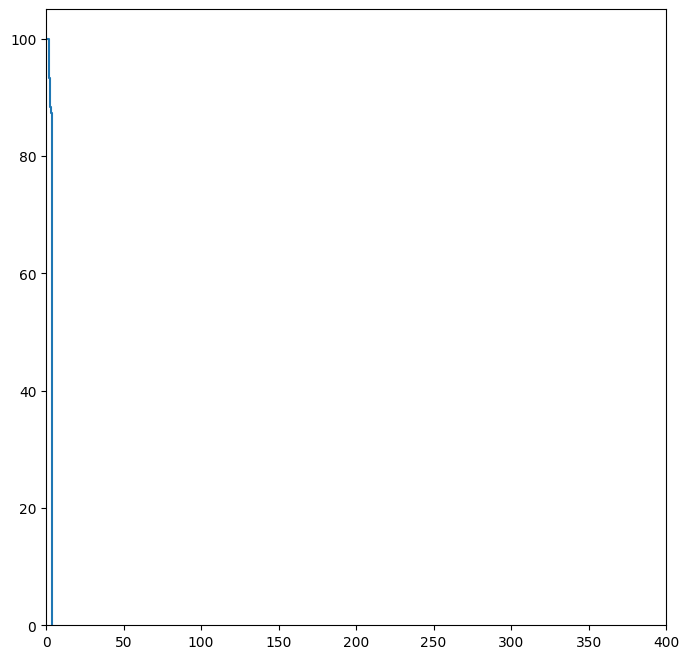

In [67]:
plt.figure(figsize=(8,8))
plt.plot(f0,p0)
plt.xlim(0,400)
plt.ylim(0,105)
#plt.plot(force, part_in_skeleton, 'o--r')


In [601]:
P

array([[0.00000000e+00, 9.49119720e-05, 0.00000000e+00],
       [1.00000000e+00, 1.36673240e-04, 0.00000000e+00],
       [2.00000000e+00, 7.16720012e-05, 0.00000000e+00],
       ...,
       [9.94500000e+03, 1.27223512e-03, 0.00000000e+00],
       [9.95900000e+03, 1.09439811e-03, 0.00000000e+00],
       [9.97900000e+03, 4.84111267e-03, 0.00000000e+00]])

In [577]:
print(sort)
print(type(P))
print(np.where(np.array(sort) == 1))
to_remove = P[np.array(sort) == 1] 
print(to_remove)

if(len(bb4) == 2):
            print('entrou')
            force.append(F)
            part_in_skeleton.append(len(act_skeleton))
            break

[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 

In [571]:
from scipy.stats import bernoulli

# create a Bernoulli distribution with probability of success p=0.7
p = 0.7
dist = bernoulli(p)

# compute the probability of success
prob_success = dist.pmf(1)   # returns 0.7

# generate a random sample of 10 outcomes
random_sample = dist.rvs(size=10)

# compute the mean of the random sample (should be close to p)
mean = random_sample.mean()

# print the results
print("Probability of success:", prob_success)
print("Random sample:", random_sample)
print("Sample mean:", mean)

from scipy.stats import bernoulli

# create a Bernoulli distribution with probability of success p=0.3
p = 0.3
dist = bernoulli(p)

# compute the PMF of the distribution
pmf = [dist.pmf(k) for k in range(2)]

# print the results
print("Bernoulli distribution with p=", p)
print("PMF:", pmf)


Probability of success: 0.7
Random sample: [0 1 1 1 1 0 1 1 1 0]
Sample mean: 0.7
Bernoulli distribution with p= 0.3
PMF: [0.7, 0.3]


In [495]:
bb3

array([[ 999,    2, -100,    3],
       [3123,   -1, -100,   -4],
       [1570,   -3, -100,    4],
       ...,
       [1358,   -2,  100,    5],
       [1158,    5,  100,    4],
       [5165,    4,  100,   -8]], dtype=int32)

In [479]:
back_bone = np.copy(bb3)
i = 999
vizinhos = [back_bone[np.sum((i - back_bone[:,1:])**2,axis = 1) == 1]]
print(type(vizinhos))

<class 'list'>


In [ ]:
## Test for filter_backbone

m = [[0,0,0,1], [1,1,0,1], [2, 2, 0, 1], [3, 1, 0, 3], [4, 1,1,1], [5, 2, 1, 1], [6, 2,1,1], [7, 0,1,1], [8, 1,1,2],[9, 3, 1, 1], [10, 2, 1, 0], [11, 5, 1, 1]
, [12, 0, 1, 4],   [13, 0, 2, 4] ]
v = np.array(m, dtype=np.int8)

v = v[v[:,2].argsort()]
print(v)

bt = filter_backbone(v, ascending= False)


In [472]:
## Filter fibril
bb2 = filter_backbone(backbone1, ascending=True)
print('subiu')
bb3 = filter_backbone(bb2, ascending=False)
print('desceu')

np.savetxt('./bb3.txt',bb3,fmt='%d')


subiu
desceu


In [507]:
## Remove rods from the backbone

t = []
r = []
f = []
back_bone1 = np.copy(bb3)
for F in range(400,550,10):
    
    print(F)
    probabilidade = generate_probability(back_bone1,F,sigma_c = 1,m = 2)
    if(len(probabilidade) == 0):
        break
    remove_ = probabilidade[probabilidade[:,1] >= 1][:,0]
    #r.append(len(remove_))
    #f.append(F)

    probabilidade = probabilidade[probabilidade[:,1] < 1]

    for i in remove_:
        back_bone1 = back_bone1[back_bone1[:,0] != i]
    t.append(np.sum(probabilidade[:,-1]))
t = np.array(t)

400
410
420
430
440
450
460
470


In [ ]:
#plt.figure(figsize = (10,10))
plt.grid(True)
plt.plot(np.array(range(0,len(ts1)*10,10)),ts1/ts1[0], label = 'ts = 1')
plt.plot(np.array(range(200,440,10)),ts1000/ts1000[0], label = 'ts = 1000')
plt.legend(loc='best')
plt.xlabel('Force applied to skeleton (F)')
plt.ylabel('% particules in skeleton')

#plt.xlim(0,400)
plt.show()

In [607]:
backbone1 = np.array(bb3).astype(int)
back_bone,N = filter_backbone(backbone1,-100,+1)
back_bone = [backbone1[np.where(np.all(i == backbone1[:,1:-1],axis = 1))[0]] for i in back_bone]
back_bone = np.array([i[0].tolist() for i in back_bone])
back_bone,N = filter_backbone(back_bone,100,-1)
back_bone = [backbone1[np.where(np.all(i == backbone1[:,1:-1],axis = 1))[0]] for i in back_bone]
back_bone = np.array([i[0].tolist() for i in back_bone]).astype(int)

In [593]:
def remover(vetor,elemento):
    a = np.arange(len(vetor))
    a = a[vetor == elemento]
    print(a)
    return a

In [338]:
bb3

array([[ 999,    2, -100,    3],
       [3123,   -1, -100,   -4],
       [1570,   -3, -100,    4],
       ...,
       [1358,   -2,  100,    5],
       [1158,    5,  100,    4],
       [5165,    4,  100,   -8]], dtype=int32)

In [392]:
np.all(np.array([[1,233,3],[4,5,6]]) in np.array([[1,8888,3],[4,5,6]]))

True

In [393]:
def calc_vizinho(back_bone,altura,camada):
    camada = [back_bone[np.sum((i - back_bone[:,1:])**2,axis = 1) == 1].tolist() for i in camada]
    camada = [i for i in camada if(i != [])]
    camada = [item for sublist in camada for item in sublist]
    camada = np.array([i for i in camada if(i[0] >altura)])
    return camada

In [467]:
def generate_back_bone2(back_bone1,inicial):
    back_bone2 = []

    back_bone1 = np.array(back_bone1).astype(int)

    #Primeira camada,
    camada = back_bone1[back_bone1[:,2] == inicial][:,1:]
    back_bone2 += camada.tolist()
    altura = inicial
    while(camada.shape[0] !=0):
        camada = [back_bone1[np.sum((i - back_bone1[:,1:])**2,axis = 1) == 1][:,1:].tolist() for i in camada]
        camada = [i for i in camada if(i != [])]
        camada = [item for sublist in camada for item in sublist]
        if(inicial <0):
            camada = np.array([i for i in camada if(i[1] >altura)])
            altura += 1
        else:
            camada = np.array([i for i in camada if(i[1] < altura)])
            altura -= 1
        if(camada.shape[0] ==0):
            break
        vizinhos = [back_bone1[np.sum((i - back_bone1[:,1:])**2,axis = 1) == 1][:,1:].tolist() for i in camada]
        vizinhos = [i for i in vizinhos if(i != [])]
        vizinhos = [item for sublist in vizinhos for item in sublist]
        vizinhos = np.array([i for i in vizinhos if(i[1] == altura)])
        camada = np.vstack((camada,vizinhos))
        final = []
        for i in camada:
            if(i.tolist() not in final):
                final.append(i.tolist())
        camada = np.array(final)
        if(camada.shape[0] !=0):
            back_bone2 += camada.tolist()
    return back_bone2

In [468]:
backbone = generate_back_bone2(backbone1,-100)
print(backbone)
#backbone = generate_back_bone2(backbone,-100)

NameError: name 'back_bone' is not defined

In [469]:
backbone

[[-1, -100, 0],
 [-1, -100, 1],
 [0, -100, 1],
 [0, -100, 0],
 [-1, -100, 2],
 [0, -100, -1],
 [-2, -100, 0],
 [-1, -100, 3],
 [-2, -100, 1],
 [0, -100, 2],
 [1, -100, 2],
 [-1, -100, -2],
 [0, -100, 3],
 [1, -100, 1],
 [1, -100, 3],
 [0, -100, -2],
 [1, -100, 0],
 [1, -100, -1],
 [-3, -100, 1],
 [-3, -100, 0],
 [1, -100, -2],
 [1, -100, 4],
 [-1, -100, 4],
 [-2, -100, 4],
 [1, -100, 5],
 [-2, -100, -2],
 [-3, -100, -2],
 [-4, -100, 1],
 [-4, -100, 0],
 [-4, -100, -1],
 [-4, -100, -2],
 [-1, -100, 5],
 [2, -100, 1],
 [2, -100, 2],
 [2, -100, 3],
 [2, -100, 4],
 [2, -100, 5],
 [3, -100, 1],
 [-4, -100, 4],
 [3, -100, 0],
 [-1, -100, -3],
 [2, -100, 0],
 [2, -100, -1],
 [-5, -100, 4],
 [-2, -100, -3],
 [3, -100, -1],
 [-3, -100, -3],
 [2, -100, -2],
 [3, -100, -2],
 [-4, -100, -3],
 [2, -100, 6],
 [-3, -100, 4],
 [4, -100, -1],
 [4, -100, -2],
 [4, -100, 0],
 [1, -100, 6],
 [-5, -100, 0],
 [-3, -100, 5],
 [4, -100, 1],
 [-5, -100, -1],
 [-5, -100, -2],
 [-6, -100, -1],
 [-4, -100, 5],
 [

In [353]:
t = []
back_bone1 = np.copy(bb3)
for F in range(200,550,10):
    
    print(F)
    probabilidade = generate_probability(back_bone1,F,sigma_c = 1,m = 2)
    if(len(probabilidade) == 0):
        break
    remove_ = probabilidade[probabilidade[:,1] >= 1][:,0]
    probabilidade = probabilidade[probabilidade[:,1] < 1]

    for i in remove_:
        back_bone1 = back_bone1[back_bone1[:,0] != i]
    t.append(np.sum(probabilidade[:,-1]))
t = np.array(t)

200
[27850.0]
210
[27850.0, 27850.0]
220
[27850.0, 27850.0, 27850.0]
230
[27850.0, 27850.0, 27850.0, 27850.0]
240
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0]
250
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0]
260
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0]
270
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0, 27601.0]
280
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0, 27601.0, 27313.0]
290
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0, 27601.0, 27313.0, 26861.0]
300
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0, 27601.0, 27313.0, 26861.0, 26499.0]
310
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0, 27601.0, 27313.0, 26861.0, 26499.0, 26223.0]
320
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0, 27601.0, 27313.0, 26861.0, 26499.0, 26223.0, 25973.0]
330
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0, 27601.0, 27313.0, 26861.0, 26499.0, 26223.0, 259

In [341]:
t[-1]

0

In [ ]:
ts1000 = np.copy(t)

In [348]:
ts1000/ts1000[0]

array([1.        , 0.9780127 , 0.9598796 , 0.9505194 , 0.94541717,
       0.93928716, 0.91337224, 0.86238667, 0.72110267, 0.52013361,
       0.35664207, 0.21888191, 0.08431524, 0.00132144, 0.        ])

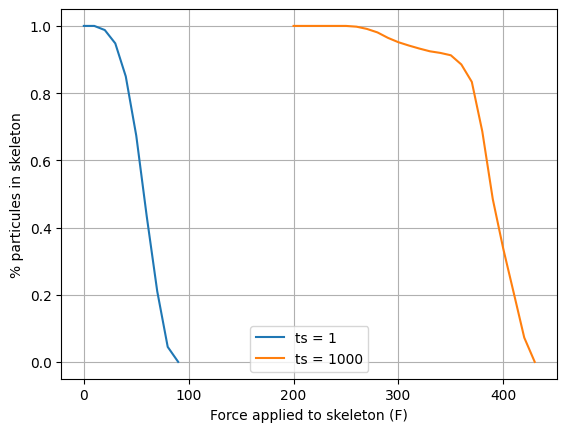

In [361]:
#plt.figure(figsize = (10,10))
plt.grid(True)
#plt.plot(np.array(range(0,len(ts1)*10,10)),ts1/ts1[0], label = 'ts = 1')
plt.plot(np.array(range(200,440,10)),ts1000/ts1000[0], label = 'ts = 1000')
plt.legend(loc='best')
plt.xlabel('Force applied to skeleton (F)')
plt.ylabel('% particules in skeleton')

#plt.xlim(0,400)
plt.show()

In [443]:
backbone = back_bone.astype(int)

In [448]:
back_bone[back_bone[:,2] == 10]

array([[182.,   0.,  10.,  -5.,   0.],
       [ 22.,   1.,  10.,   2.,   0.],
       [  4.,   1.,  10.,  -1.,   0.],
       [ 37.,   0.,  10.,   1.,   0.],
       [ 53.,   0.,  10.,  -4.,   0.],
       [  8.,   2.,  10.,  -1.,   0.],
       [156.,   3.,  10.,  -1.,   0.],
       [ 89.,  -1.,  10.,   1.,   0.],
       [125.,   3.,  10.,  -2.,   0.],
       [ 30.,   1.,  10.,   3.,   0.]])

[array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape

In [ ]:
with open("/home/robert/gitrepos/dla-collagen/back_bone_teste.txt", 'w') as fid:
    for i in back_bone1:
        x = str(int(i[1]))
        y = str(int(i[2]))
        z = str(int(i[3]))
        fid.write('%s %s %s \n' %(x,y,z))

In [ ]:
np.savetxt("./back.txt", back_bone[:,1:-1],fmt = "%d", delimiter=' ')

In [ ]:
back_bone

array([[ 237,   -4,  100,    4,    0],
       [2213,   -2,  100,   -7,    0],
       [3577,   -2,  100,   -5,    0],
       ...,
       [2660,    1, -100,   -8,    0],
       [5179,    4, -100,    1,    0],
       [ 979,   -5, -100,   -5,    0]])

In [ ]:
##

F = 1
stress_i = np.array(201)


array([[  1, -99,   0],
       [  0, -99,   0],
       [ -1, -99,   1],
       [ -1, -99,  -4],
       [ -2, -99,  -4],
       [  0, -99,  -4],
       [  0, -99,  -3],
       [  4, -99,  -2],
       [ -4, -99,   1],
       [ -3, -99,   1],
       [  5, -99,  -2],
       [ -5, -99,   0],
       [ -3, -99,   0],
       [  2, -99,   2],
       [ -6, -99,   0],
       [ -7, -99,   0],
       [  3, -99,  -7],
       [ -7, -99,  -1],
       [  5, -99,  -1],
       [  5, -99,   0],
       [  6, -99,  -1],
       [  0, -99,   6],
       [ -3, -99,  -4],
       [  1, -99,  -4],
       [ -4, -99,  -4],
       [  6, -99,  -5],
       [  7, -99,  -5],
       [ -5, -99,  -4],
       [  0, -99,   7],
       [ -4, -99,  -5],
       [  6, -99,  -4],
       [  9, -99,  -7],
       [  7, -99,  -4],
       [  5, -99,   6],
       [  9, -99,  -8],
       [ -1, -99,   7],
       [  8, -99,  -8],
       [ -2, -99,   7],
       [  5, -99,   7],
       [ -7, -99,   4],
       [  8, -99,  -4],
       [  7, -99

(47, 3)

In [ ]:
#print(len(back_bone1))
back_bone2 = []
print('tamanho back_bone1: %d' %len(back_bone1))

### Encotra todas as part. da primeira camada(y = -100) e marca como conectado
for j in back_bone1:
            
    if j[2] == -100:
        #print(entrou)
        part = [j[0], j[1], j[2], j[3], j[4] +1]
        back_bone2.append(part)
        #print(back_bone2)

    else:
        continue

### Encontra os vizinhos na segunda camada das part. marcadas na primeira camada
layer = []
plane = []
for i in back_bone2:
    part = [i[0], i[1], i[2]  + 1, i[3], i[4]]
    
    for j in back_bone1:

        if part[1] == j[1] and part[2] == j[2] and part[3] == j[3]:
            part[4] = 1
            layer.append(part)
        
print(len(layer))

### Encontra os vizinhos das part. na segunda camada
print(len(layer))
for i in layer:
    neigh1 = [i[0], i[1] + 1, i[2], i[3], i[4]]
    neigh2 = [i[0], i[1] - 1, i[2], i[3], i[4]]
    neigh3 = [i[0], i[1], i[2], i[3] + 1, i[4]]
    neigh4 = [i[0], i[1], i[2], i[3] - 1, i[4]]


    for j in back_bone1:

        if neigh1[1] == j[1]:
            if neigh1[2] == j[2]:
                if neigh1[3] == j[3]:
                    neigh1[4] = 1
                    layer.append(neigh1)

        if neigh2[1] == j[1]:
            if neigh2[2] == j[2]:
                if neigh2[3] == j[3]:
                    neigh2[4] = 1
                    layer.append(neigh2)

        if neigh3[1] == j[1]:
            if neigh3[2] == j[2]:
                if neigh3[3] == j[3]:
                    neigh3[4] = 1
                    layer.append(neigh3)

        if neigh4[1] == j[1]:
            if neigh4[2] == j[2]:
                if neigh4[3] == j[3]:
                    neigh4[4] = 1
                    layer.append(neigh4)



        

#print('plane: %d' %len(plane))
print(len(layer))
### Adiciona as part. conectadas da segunda camada no back_bone2


tamanho back_bone1: 8431
45
45


KeyboardInterrupt: 

In [ ]:
for i in back_bone1:
    if i[2] == -99:
        #print(i)
        #print(type(i))
        c = 0
a = [112, -1, -98, 1, 0]
if a in back_bone1:
    print("ok")
else:
    print('no')


no


In [ ]:
part = [51.0, 0.0, -99.0, 0.0, 1]
for i in back_bone1:
    if part[1] == i[1] and part[2] == i[2] and part[3] == i[3]:
        print(part)
        print(i)

[51.0, 0.0, -99.0, 0.0, 1]
[51.0, 0.0, -99.0, 0.0, 0.0]


In [ ]:
for i in back_bone1:

    if i[2] == -99:
        print(i)

[51.0, 0.0, -99.0, 0.0, 0.0]
[112.0, -2.0, -99.0, 1.0, 0.0]
[136.0, -2.0, -99.0, -4.0, 0.0]
[138.0, -3.0, -99.0, -4.0, 0.0]
[144.0, -1.0, -99.0, -4.0, 0.0]
[171.0, -1.0, -99.0, -3.0, 0.0]
[196.0, 3.0, -99.0, -2.0, 0.0]
[248.0, -5.0, -99.0, 1.0, 0.0]
[287.0, 4.0, -99.0, -2.0, 0.0]
[302.0, -6.0, -99.0, 0.0, 0.0]
[313.0, -4.0, -99.0, 0.0, 0.0]
[338.0, 1.0, -99.0, 2.0, 0.0]
[355.0, 4.0, -99.0, -5.0, 0.0]
[414.0, -7.0, -99.0, 0.0, 0.0]
[417.0, -8.0, -99.0, 0.0, 0.0]
[420.0, 2.0, -99.0, -7.0, 0.0]
[437.0, -8.0, -99.0, -1.0, 0.0]
[438.0, 4.0, -99.0, -1.0, 0.0]
[458.0, 4.0, -99.0, 0.0, 0.0]
[470.0, 5.0, -99.0, -1.0, 0.0]
[549.0, -4.0, -99.0, 5.0, 0.0]
[553.0, -1.0, -99.0, 6.0, 0.0]
[584.0, -4.0, -99.0, -4.0, 0.0]
[674.0, 0.0, -99.0, -4.0, 0.0]
[698.0, -5.0, -99.0, -4.0, 0.0]
[704.0, 5.0, -99.0, -5.0, 0.0]
[758.0, 6.0, -99.0, -5.0, 0.0]
[764.0, -6.0, -99.0, -4.0, 0.0]
[905.0, -1.0, -99.0, 7.0, 0.0]
[979.0, -5.0, -99.0, -5.0, 0.0]
[1003.0, 5.0, -99.0, -4.0, 0.0]
[1046.0, 8.0, -99.0, -7.0, 0.0]
[

In [ ]:
#print(back_bone2)
with open("/home/robert/gitrepos/dla-collagen/back_bone2_teste.txt", 'w') as fid:
    for i in back_bone2:
        x = str(int(i[1]))
        y = str(int(i[2]))
        z = str(int(i[3]))
        fid.write('%s %s %s \n' %(x,y,z))

[[51.0, 0.0, -99.0, 0.0, 0], [67.0, -1.0, -99.0, 0.0, 0], [112.0, -2.0, -99.0, 1.0, 0], [136.0, -2.0, -99.0, -4.0, 0], [138.0, -3.0, -99.0, -4.0, 0], [144.0, -1.0, -99.0, -4.0, 0], [171.0, -1.0, -99.0, -3.0, 0], [196.0, 3.0, -99.0, -2.0, 0], [248.0, -5.0, -99.0, 1.0, 0], [271.0, -4.0, -99.0, 1.0, 0], [287.0, 4.0, -99.0, -2.0, 0], [302.0, -6.0, -99.0, 0.0, 0], [313.0, -4.0, -99.0, 0.0, 0], [338.0, 1.0, -99.0, 2.0, 0], [414.0, -7.0, -99.0, 0.0, 0], [417.0, -8.0, -99.0, 0.0, 0], [420.0, 2.0, -99.0, -7.0, 0], [437.0, -8.0, -99.0, -1.0, 0], [438.0, 4.0, -99.0, -1.0, 0], [458.0, 4.0, -99.0, 0.0, 0], [470.0, 5.0, -99.0, -1.0, 0], [553.0, -1.0, -99.0, 6.0, 0], [584.0, -4.0, -99.0, -4.0, 0], [674.0, 0.0, -99.0, -4.0, 0], [698.0, -5.0, -99.0, -4.0, 0], [704.0, 5.0, -99.0, -5.0, 0], [758.0, 6.0, -99.0, -5.0, 0], [764.0, -6.0, -99.0, -4.0, 0], [905.0, -1.0, -99.0, 7.0, 0], [979.0, -5.0, -99.0, -5.0, 0], [1003.0, 5.0, -99.0, -4.0, 0], [1046.0, 8.0, -99.0, -7.0, 0], [1065.0, 6.0, -99.0, -4.0, 0], [1